In [18]:
%reload_ext autoreload
%autoreload 2

In [19]:
import os
import numpy as np
import pandas as pd
from linescanning import *
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import cortex
from linescanning.bin.utils.utils import format_graph, errorfill
from scipy.stats import sem
from sklearn.metrics import auc
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None
opj = os.path.join

In [20]:
PROJECT = "URIS-MDD"
base,place = utils.get_base_dir()

proj = opj(base, 'projects', PROJECT)
fs_dir = opj(proj, 'derivatives','freesurfer')
nighres_dir = opj(proj, 'derivatives','nighres')
ctx_dir = opj(proj, 'derivatives','pycortex')

mask_dir = opj(proj, 'derivatives','manual_masks')

# MUST MATCH ORDER IN ROI.JSON
roi_list = ['rACC','mOFC','lPFC']
# roi_list = [f'{hemi}_{i}' for i in roi_list for hemi in ['lh','rh']]
roi_list

['rACC', 'mOFC', 'lPFC']

In [21]:
import glob

pname = opj(fs_dir, 'fsaverage', 'volumes')
surf_list = glob.glob(pname+'/*T1map.npy')
surf_list.sort()
# print(surf_list)
exclude_subjs = ['008','021','032', '034','064','069','089','113','133','140','170']
surf_avg = []
for file in surf_list:
    if not any(ID in file for ID in exclude_subjs):
        surf_avg.append(np.load(file)[...,np.newaxis])
    else:
        print(f"excluding {file}")

surf_data = np.concatenate(surf_avg, axis=-1)
surf_avg = surf_data.mean(axis=-1)
surf_std = surf_data.std(axis=-1)

surf_avg_v = cortex.Vertex(surf_avg, subject='fsaverage', vmin=1300, vmax=2000, cmap='viridis')
surf_std_v = cortex.Vertex(surf_std, subject='fsaverage', cmap='viridis')

surf_001 = cortex.Vertex(np.load(surf_list[-1]), subject='fsaverage', vmin=1500, vmax=2000, cmap='viridis')

In [22]:
surf_list

['/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-001_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-003_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-004_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-006_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-007_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-009_hemi-LR_space-fsaverage_desc-T1map.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/freesurfer/fsaverage/volumes/sub-014_hemi-LR_space-fsaverage_desc-T1map.npy',

Started server on port 56337


<JS: window.viewer>

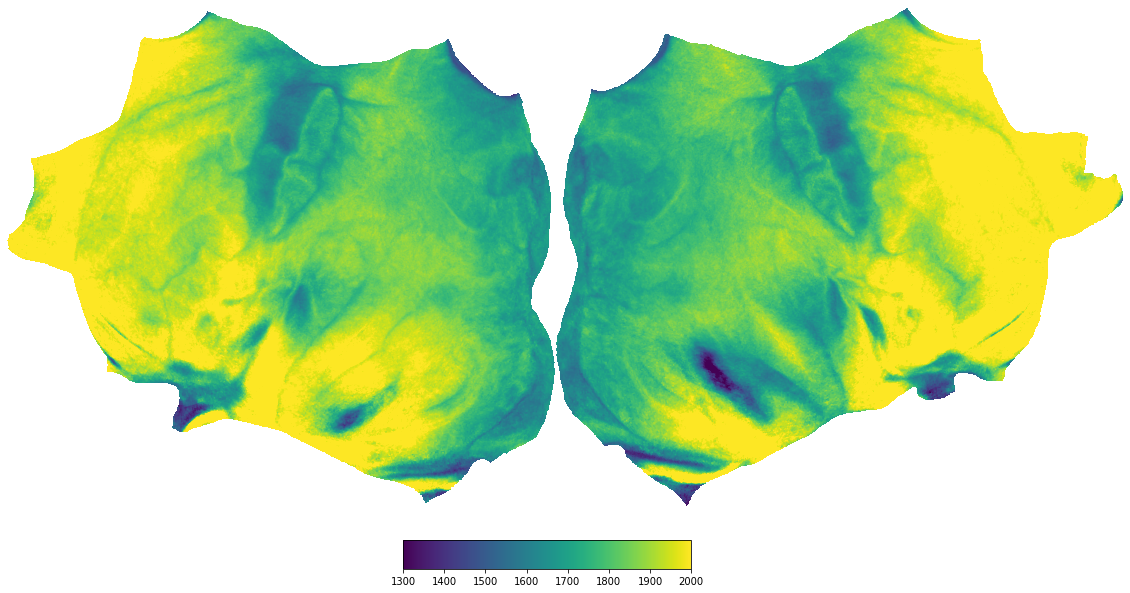

In [23]:
fig,axs = plt.subplots(figsize=(20,10))
cortex.quickshow(surf_avg_v, with_colorbar=True, with_rois=False, with_sulci=False, with_labels=True, with_curvature=True, fig=axs)
cortex.webshow(surf_avg_v, with_rois=False, with_labels=False)

In [24]:
def find_info(file):
    
    roi = None
    hh = None
    for ii in roi_list:
        if ii in file:
            roi = ii
            if 'hemi-L_' in file:
                hh = 'hemi-L'
            elif 'hemi-R_' in file:
                hh = 'hemi-R'
            elif 'hemi-LR_' in file:
                hh = 'hemi-LR'            
            else:
                raise ValueError(f"Could not find hemi-R or hemi-L in {file}")
    
    return roi,hh

def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]    

In [25]:
# 2nd order polynomial
def func(x, a, b, c):
	return a * x + b * x**2 + c

In [26]:
rois = json.load(open(opj(proj, 'roi_cortex.json')))

exclude_subjs = ['008','034','064','069','140','170','998']

con_arr = []
mdd_arr = []
con_surf = []
mdd_surf = []

for num,sub in enumerate(['sub-999']):
    ID = "999"
    DIAG = "HC"
    subj_arr = []
    
    if ID in exclude_subjs:
        print(f"Sub-{ID} has been excluded from analysis")
    else:
        print(f"----------------------------------- sub-{ID} -----------------------------------")
        # first run:
        # master -m 15,20,21,22,23,26

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------
        if not os.path.exists(opj(nighres_dir, sub, 'ses-1', 'profiling')):
            os.system(f"mkdir -p {opj(nighres_dir, sub, 'ses-1', 'profiling')}")

        t1_prof = utils.get_file_from_substring("desc-profile_T1map", opj(nighres_dir, sub, 'ses-1', 'profiling'))
        t2s_prof = utils.get_file_from_substring("desc-profile_T2s", opj(nighres_dir, sub, 'ses-1', 'profiling'))        
        layer_file = utils.get_file_from_substring("boundaries", opj(nighres_dir, sub, 'ses-1', 'layering'))
        t1_file = utils.get_file_from_substring("T1map.nii.gz", opj(proj, sub, 'ses-1', 'anat'))
        r2s_file = utils.get_file_from_substring("R2s.nii.gz", opj(proj, sub, 'ses-1', 'anat'))
        t2s_file = opj(os.path.dirname(r2s_file), f"{sub}_ses-1_acq-MEMP2RAGE_T2starmap.nii.gz")
        atlas = utils.get_file_from_substring("aparc.DKTatlas+aseg", opj(fs_dir, sub, 'mri'))
        cruise_gm = utils.get_file_from_substring("cruise_gm", opj(mask_dir, sub, 'ses-1'))
        cruise_img = utils.get_file_from_substring("cruise_cortex", opj(nighres_dir, sub, 'ses-1', 'cruise'))

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------

        if not t1_prof and layer_file and t1_file:
            cmd = f"call_nighresprofsamp -l {layer_file} -s {t1_file} -d {opj(nighres_dir, sub, 'ses-1', 'profiling')} -n {sub}_ses-1_acq-MEMP2RAGE_desc-profile_T1map"
            os.system(cmd)
            t1_prof = utils.get_file_from_substring("desc-profile_T1map", opj(nighres_dir, sub, 'ses-1', 'profiling'))

        if not t1_prof or not t1_file or not atlas:
            print("nothing to do")
            continue
        
        # make t2*-map
        # if r2s_file and not os.path.exists(t2s_file):

        #     from nilearn import image

        #     t2s = image.math_img('1/r2s', r2s=r2s_file)
        #     t2s.to_filename(t2s_file)

        # if not t2s_prof and layer_file and t2s_file:
        #     cmd = f"call_nighresprofsamp -l {layer_file} -s {t2s_file} -d {opj(nighres_dir, sub, 'ses-1', 'profiling')} -n {sub}_ses-1_acq-MEMP2RAGE_desc-profile_T2s"
        #     os.system(cmd)
        #     t2s_prof = utils.get_file_from_substring("desc-profile_T2s", opj(nighres_dir, sub, 'ses-1', 'profiling'))       

        use_profile = "T1map"
        if use_profile == "T1map":
            prof_file = t1_prof
            sample_file = t1_file
        elif use_profile == "T2s":
            prof_file = t2s_prof 
            sample_file = t2s_file

        if cruise_img:
            print(f"Splitting CRUISE: {cruise_img}")
            bname = f"{sub}_ses-1_acq-MEMP2RAGE"
            cmd = f"call_splitcruise {cruise_img} {opj(os.path.dirname(cruise_img), bname)}"
            os.system(cmd)

            cruise_gm = utils.get_file_from_substring("cruise_gm", os.path.dirname(cruise_img))
            print(f"CRUISE ribbon: {cruise_gm}")            

        #---------------------------------------------------------------------------------------------------------------------------------------------------------------------

        for i,r in enumerate(roi_list):

            for pp in ['left','right']:

                if pp == "left":
                    hemi_tag = 'hemi-L'
                elif pp == "right":
                    hemi_tag = 'hemi-R'

                out_img = opj(os.path.dirname(t1_prof), f"{sub}_ses-1_roi-{r}_{hemi_tag}.nii.gz")

                if not os.path.exists(out_img):
                    cmd = f"call_fs2mask {atlas} '{rois['ROI'][i][pp]}' {out_img} {t1_file}"
                    # print('\n', cmd)
                    os.system(cmd)

                    # dilate twice with 2D kernel, multiply with CRUISE-cortex img, and keep largest component
                    # cmd = f"fslmaths {out_img} -kernel 2D -dilD {out_img}"
                    cmd = f"call_dilate {out_img} {out_img} 2 {cruise_gm}"
                    os.system(cmd)

                    # multiply with good ribbon
                    print(f"Multiplying {os.path.basename(out_img)} with {os.path.basename(cruise_gm)}")
                    cmd = f"fslmaths {out_img} -mul {cruise_gm} {out_img}"
                    os.system(cmd)

                    # keep largest component to get rid of weird small voxels in the other hemisphere
                    cmd = f"call_largestcomponent {out_img}"
                    os.system(cmd)

                out_txt = opj(os.path.dirname(prof_file), f"{sub}_ses-1_roi-{r}_{hemi_tag}_{use_profile}.txt")
                if not os.path.exists(out_txt):
                    cmd = f"fslmeants -i {prof_file} -m {out_img} -o {out_txt}"
                    print("extracting data from profile_sampling file with mask")
                    os.system(cmd)
                    
        roi_files = []
        for kk in os.listdir(os.path.dirname(prof_file)):
            if kk.endswith(f"{use_profile}.txt"):
                if any(roi in kk for roi in roi_list):
                    roi_files.append(kk)

        roi_files.sort()

        # average files:
        chunk_list = list(divide_chunks(roi_files, 2))
        for chunk in range(len(chunk_list)):
            area = find_info(opj(os.path.dirname(prof_file),chunk_list[chunk][0]))[0]
            avg_roi = opj(os.path.dirname(prof_file), f"{sub}_ses-1_roi-{area}_hemi-LR_{use_profile}.txt")
            
            if not os.path.exists(avg_roi):
                f1 = np.loadtxt(opj(os.path.dirname(prof_file),chunk_list[chunk][0])).reshape(1,11)
                f2 = np.loadtxt(opj(os.path.dirname(prof_file),chunk_list[chunk][1])).reshape(1,11)

                avg = np.mean(np.vstack((f1,f2)), axis=0)
                np.savetxt(avg_roi,avg)


        roi_files = []
        for kk in os.listdir(os.path.dirname(prof_file)):
            if kk.endswith(f"{use_profile}.txt"):
                if any(roi in kk for roi in roi_list):
                    roi_files.append(kk)

        roi_files.sort()

        roi_data = []
        for ff in roi_files:
            roi,hemi = find_info(ff)
            
            if hemi != "hemi-LR":
                data = np.loadtxt(opj(os.path.dirname(prof_file),ff)).reshape(1,11)

                # full_data[f'avg_{roi}_{hemi}_{use_profile}'][num] = data.mean()
                # calculate AUC
                AUC = auc(np.arange(0,11), np.squeeze(data))
                # full_data[f'auc_{roi}_{hemi}_{use_profile}'][num] = AUC

                # fit 2nd order polynomial (quadratic function)
                xx = np.arange(0,data.shape[-1])
                popt, pcov = curve_fit(func, xx, np.squeeze(data))

                # for idx,par in enumerate(['a','b','c']):
                    # full_data[f'{par}_poly_{roi}_{hemi}_{use_profile}'][num] = popt[idx]

                # print(f'auc_{roi}_{hemi}: {round(AUC,2)}; curve: {popt}')
                roi_data.append(data)

        roi_data = np.array(roi_data)[...,np.newaxis]
        roi_data = np.concatenate(roi_data, axis=2)

        # # get surface file
        # surf_file = opj(fs_dir, 'fsaverage', 'volumes', f"{sub}_hemi-LR_space-fsaverage_desc-{use_profile}.npy")
        # if not os.path.exists(surf_file):
        #     cmd=f"call_vol2fsaverage {sub} {sample_file} {use_profile}"
        #     os.system(cmd)

        # get group membership
        if DIAG == "MDD":
            mdd_arr.append(roi_data)
            # mdd_surf.append(np.load(surf_file)[...,np.newaxis])
        elif DIAG == "HC":
            con_arr.append(roi_data)
            # con_surf.append(np.load(surf_file)[...,np.newaxis])
        else:
            raise ValueError(f"Unrecognized group membership: {DIAG}. Should be either 'HC' or 'MDD'")

if mdd_arr:
    mdd_data = np.concatenate(mdd_arr)

if con_arr:
    con_data = np.concatenate(con_arr)

# if mdd_surf:
#     mdd_surf = np.concatenate(mdd_surf, axis=-1)
#     if mdd_surf.shape[-1] > 1:
#         mdd_surf_avg = mdd_surf.mean(axis=-1)
#         mdd_surf_std = mdd_surf.std(axis=-1)
#     else:
#         mdd_surf_avg = None
#         mdd_surf_std = None

# if con_surf:
#     con_surf = np.concatenate(con_surf, axis=-1)
#     if con_surf.shape[-1] > 1:
#         con_surf_avg = mdd_surf.mean(axis=-1)
#         con_surf_std = mdd_surf.std(axis=-1)
#     else:
#         con_surf_avg = None
#         con_surf_std = None
# if con_surf_avg and mdd_surf_avg:
#     surf_diff = con_surf_avg - mdd_surf_avg


print('Done\n')

----------------------------------- sub-999 -----------------------------------
Splitting CRUISE: /data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/nighres/sub-999/ses-1/cruise/sub-999_ses-1_acq-MEMP2RAGE_desc-cruise_cortex.nii.gz
CRUISE ribbon: /data1/projects/MicroFunc/Jurjen/projects/URIS-MDD/derivatives/nighres/sub-999/ses-1/cruise/sub-999_ses-1_acq-MEMP2RAGE_desc-cruise_gm.nii.gz
Done



In [27]:
color_list = [rois['ROI'][i]['color'] for i,x in enumerate(rois['ROI'])]
color_list = [i for i in color_list for hemi in ['lh', 'rh']]
color_list

['#7d64a0',
 '#7d64a0',
 '#c8234b',
 '#c8234b',
 '#14dca0',
 '#14dca0',
 '#b42878',
 '#b42878',
 '#ffc020',
 '#ffc020']

In [28]:
popt

array([  33.631,    2.289, 1780.546])

(11, 6)


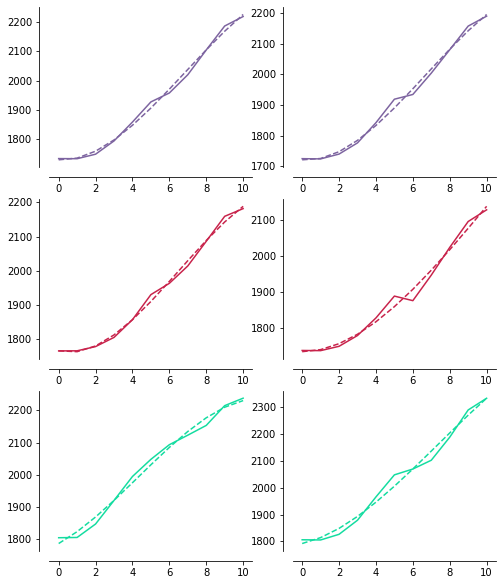

In [48]:
fav_subj = con_data[0,...]
print(fav_subj.shape)

colors = sns.color_palette('viridis',2)

fig,axs = plt.subplots(3,2, figsize=(8,10))

# 2nd order polynomial
# def func(x, a, b):
# 	return a * x + b

MSE_rois = []
R2_rois = []
for i, ax in enumerate(fig.axes):
        
    ax.plot(fav_subj[...,i], color=color_list[i])
    
    # plot fit
    xx = np.arange(0,fav_subj[...,i].shape[0])
    popt, pcov = curve_fit(func, xx, fav_subj[...,i])
    
    yy = func(xx, *popt)
    ax.plot(xx, yy, color=color_list[i], ls='--')
    
    # verts = [(0, np.amin(yy)), *zip(xx, yy), (xx.shape[0]-1, np.amin(yy))]
    # poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    # ax.add_patch(poly)
    
sns.despine(offset=10)

In [49]:
func

<function __main__.func(x, a, b, c, d)>

In [30]:
import pickle
fprof = utils.get_file_from_substring("T1map.pkl", opj(proj, 'derivatives', 'statistics'))
with (open(fprof, "rb")) as openfile:
    t1_profile_data = pickle.load(openfile)

fprof = utils.get_file_from_substring("T2starmap.pkl", opj(proj, 'derivatives', 'statistics'))
with (open(fprof, "rb")) as openfile:
    t2s_profile_data = pickle.load(openfile)

t1_profile_data

{'con_avg': array([[1724.624, 1732.096, 1761.244, 1759.278, 1800.682, 1772.436],
        [1725.267, 1732.813, 1762.029, 1760.179, 1801.867, 1772.838],
        [1734.96 , 1742.724, 1770.243, 1767.669, 1818.737, 1787.759],
        [1759.678, 1766.298, 1793.387, 1791.379, 1856.86 , 1827.787],
        [1797.601, 1803.763, 1828.148, 1820.054, 1901.046, 1875.957],
        [1834.935, 1843.484, 1846.075, 1855.538, 1940.214, 1911.461],
        [1862.983, 1871.375, 1885.35 , 1874.241, 1958.061, 1932.541],
        [1889.352, 1890.679, 1897.045, 1895.162, 1975.533, 1953.806],
        [1913.978, 1909.442, 1914.57 , 1912.621, 1986.573, 1974.052],
        [1931.592, 1922.039, 1928.001, 1925.125, 1996.714, 1993.914],
        [1933.353, 1922.803, 1931.503, 1917.222, 1997.58 , 1999.194]]),
 'con_err': array([[33.576, 30.508, 35.595, 34.46 , 33.447, 47.077],
        [33.806, 30.743, 35.881, 34.364, 33.549, 47.222],
        [34.378, 32.161, 36.633, 34.991, 35.457, 49.038],
        [36.331, 34.664, 38.998,

In [32]:
# g1.plot(all_data[[step], color=rois['ROI'][i]['color'])
mdd_color = "#08B2F0"
con_color = "#cccccc"

In [35]:
chunked_con_avg_t1 = list(divide_chunks(t1_profile_data['con_avg'].T, 2))
chunked_con_err_t1 = list(divide_chunks(t1_profile_data['con_err'].T, 2))
chunked_mdd_avg_t1 = list(divide_chunks(t1_profile_data['mdd_avg'].T, 2))
chunked_mdd_err_t1 = list(divide_chunks(t1_profile_data['mdd_err'].T, 2))

chunked_con_avg_t2 = list(divide_chunks(t2s_profile_data['con_avg'].T, 2))
chunked_con_err_t2 = list(divide_chunks(t2s_profile_data['con_err'].T, 2))
chunked_mdd_avg_t2 = list(divide_chunks(t2s_profile_data['mdd_avg'].T, 2))
chunked_mdd_err_t2 = list(divide_chunks(t2s_profile_data['mdd_err'].T, 2))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


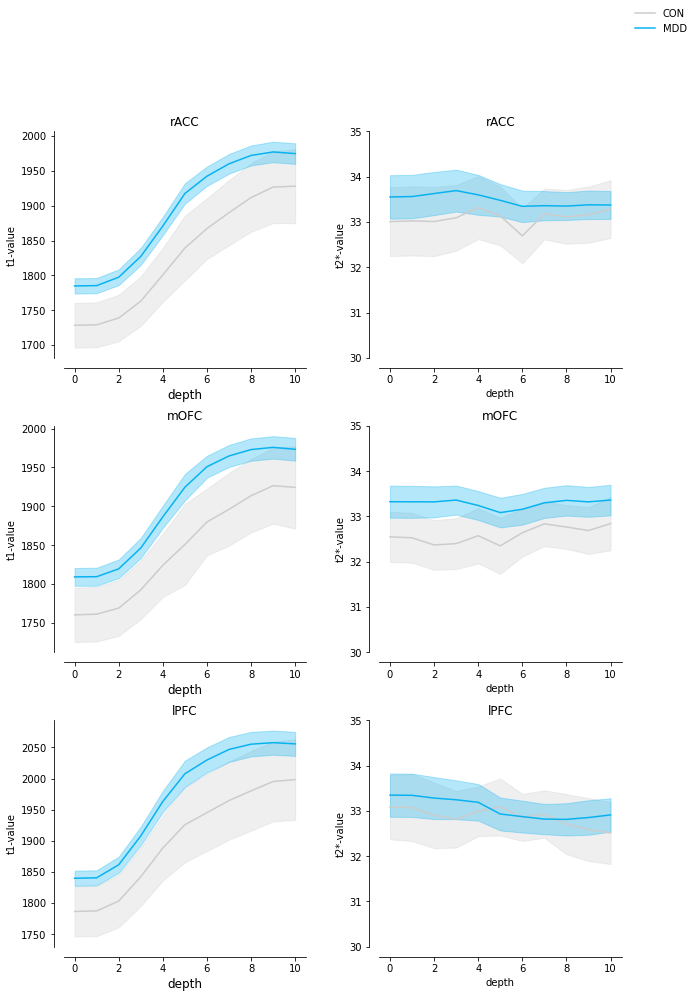

In [36]:
fig = plt.figure(figsize=(10,15))
gs1 = gridspec.GridSpec(len(roi_list),2)
gs1.update(hspace=0.3, wspace=0.3)
x_axis = np.arange(0,11)

# import random
# random_list = random.sample(range(0,50),11)

step = 0
for i,r in enumerate(roi_list):

    if step == 0:
        g1 = fig.add_subplot(gs1[step])
    else:
        g1 = fig.add_subplot(gs1[step], sharex=g1)
    
    
    errorfill(x_axis,chunked_con_avg_t1[i].mean(axis=0), chunked_con_err_t1[i].mean(axis=0), color=con_color)
    errorfill(x_axis,chunked_mdd_avg_t1[i].mean(axis=0), chunked_mdd_err_t1[i].mean(axis=0), color=mdd_color)
    g1.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t1-value",title=f"{r}")
    g1.set_xlabel("depth", fontname='Arial').set_fontsize(12)
    sns.despine(offset=10)

    step += 1

    g2 = fig.add_subplot(gs1[step], sharex=g1)
    errorfill(x_axis,chunked_con_avg_t2[i].mean(axis=0), chunked_con_err_t2[i].mean(axis=0), color=con_color)
    errorfill(x_axis,chunked_mdd_avg_t2[i].mean(axis=0), chunked_mdd_err_t2[i].mean(axis=0), color=mdd_color)
    g2.set_xticks(np.arange(0,11, step=2))
    format_graph("depth","t2*-value",title=f"{r}")
    g2.set_ylim([30,35])
    sns.despine(offset=10)

    step += 1

fig.legend(labels=['CON','MDD'], frameon=False)
# fig.savefig(opj(proj, 'code', 'figures', 'fig2', 'uris_profiles.svg'), dpi=300)
plt.show()

In [59]:
print(t1_profile_data['con_avg'][...,0])
print(t1_profile_data['mdd_avg'][...,0])

[1724.624 1725.267 1734.96  1759.678 1797.601 1834.935 1862.983 1889.352
 1913.978 1931.592 1933.353]
[1775.781 1776.13  1788.544 1818.264 1860.58  1904.884 1929.84  1949.447
 1963.185 1970.401 1969.603]


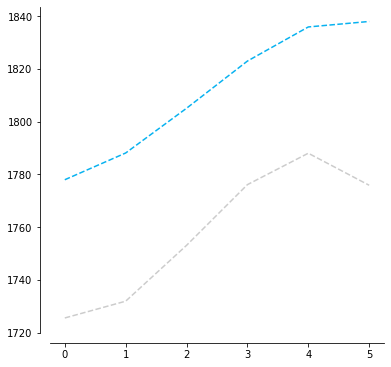

[  -5.358   13.879   -2.159 1725.526] [   4.763    6.356   -0.982 1777.93 ]


In [53]:
fig,axs = plt.subplots(figsize=(6,6))

def func(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d

# avg = chunked_con_avg_t1[0].mean(axis=0)
avg_con= t1_profile_data['con_avg'][0]
avg_mdd= t1_profile_data['mdd_avg'][0]
# plot fit
xx = np.arange(0,avg_con.shape[0])
popt1, pcov1 = curve_fit(func, xx, avg_con)
popt2, pcov2 = curve_fit(func, xx, avg_mdd)

yy1 = func(xx, *popt1)
yy2 = func(xx, *popt2)
# axs.plot(xx,avg)
axs.plot(xx, yy1, color=con_color, ls='--')
axs.plot(xx, yy2, color=mdd_color, ls='--')
sns.despine(offset=10)
plt.show()

print(popt1, popt2)

In [54]:
from scipy.stats import ttest_ind
ttest_ind(popt1[-1],popt[-1])

/home/heij/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/heij/.local/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)

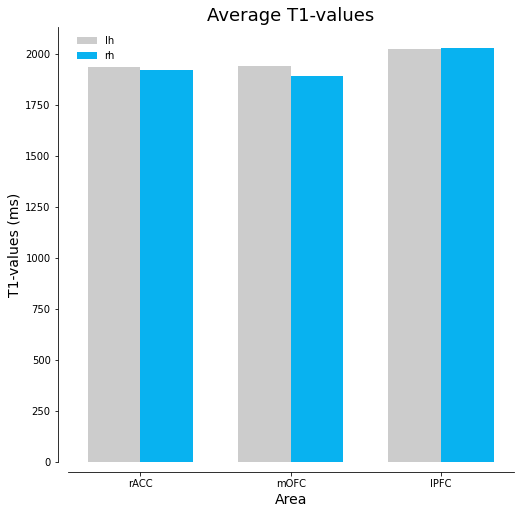

In [25]:
lh_roi = fav_subj[...,::2]
rh_roi = fav_subj[...,1::2]

fig, axs = plt.subplots(figsize=(8,8))
x_axis = np.arange(0,rh_roi.shape[-1])
width = 0.35       # the width of the bars

# plot avg T1
axs.set_xticks(x_axis+width/2)
axs.set_xticklabels(roi_list)
rects1 = axs.bar(x_axis, lh_roi.mean(axis=0), width, color=con_color, label='lh', align='center')
rects2 = axs.bar(x_axis+width, rh_roi.mean(axis=0), width, color=mdd_color, label='rh', align='center')
axs.set_xlabel("Area").set_fontsize(14)
axs.set_ylabel("T1-values (ms)").set_fontsize(14)
axs.set_title("Average T1-values").set_fontsize(18)
axs.legend(frameon=False)
sns.despine(offset=10)